In [27]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import models, transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision import transforms

from torch.utils.data import DataLoader, SubsetRandomSampler

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import torch.cuda.amp as amp

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
bases_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Dataset/"
models_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Models/"

train_dataset_path = bases_path + "personal_Cleansed"
test_dataset_path = bases_path + "test/"
model_save_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Models/best_model.pth"  # Chemin de sauvegarde du modèle

In [30]:
batch_size = 32  # @param [1,2,4,8,16,24,26, 32,64,128, 256] {type:"raw"}

input_dim = 224  # @param [32, 224,256,299,380] {type:"raw"}
image_size = (input_dim, input_dim)

epochs = 10  # @param [1, 5, 10,20,30,50,75, 100,200] {type:"raw"}

train_split = 0.9  # @param [0.9] {type:"raw"}

validation_split = 0.1  # @param [1e-1,2e-1,3e-1,4e-1] {type:"raw"}

# -------------------------
# Early Stopping call Back
# -------------------------
early_patience = 5 # @param [1,2,3,5,10,15,20,50,100] {type:"raw"}

optimizer_cost_function_train = "Adam"  # @param ["Adam", "SGD"]
train_learning_rate = 0.001 # @param [0.1,0.01,0.03, 0.003,0.0003,0.001,0.005,0.0001,0.00001] {type:"raw"}

optimizer_cost_function_refine = "SGD"  # @param ["Adam", "SGD"]
refine_learning_rate = 0.01 # @param [0.1,0.01,0.03,0.001,0.005,0.0001,0.00001] {type:"raw"}

dropout_rate = 0.5 # @param [0.0,0.1,0.2,0.3,0.4,0.5] {type:"raw"}

l2_rate = 0.00003 # @param [0,0.03,0.003,0.0003,0.00003] {type:"raw"}

nb_nodes = 1024 # @param [512,1024,2048] {type:"raw"}

head_layer = 5 # @param [1,2,3,4,5,6,7,8,12,20] {type:"raw"}

last_level = 256 # @param [128,256,512] {type:"raw"}

In [31]:
class ModelCheckpointCallback:
    def __init__(self, epoch_to_save, model_save_path):
        self.epoch_to_save = epoch_to_save
        self.model_save_path = model_save_path
        self.best_accuracy = 0.0

    def __call__(self, epoch, model, accuracy):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            torch.save(model.state_dict(), self.model_save_path)
            print(f'Model saved at epoch {epoch} with accuracy {accuracy:.3f}')

In [32]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct, total

In [33]:
# Charger MobileNetV3-Small pré-entraîné
weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = models.mobilenet_v3_small(weights=weights)

In [34]:
# Adapter la dernière couche pour 3 classes
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 3)

In [35]:
# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [36]:
# Afficher le modèle
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [37]:
# Transformations pour les données d'entraînement et de validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [38]:
# Charger les données
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)

In [39]:
# Créer des indices pour le split train/validation
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(indices, test_size=validation_split, random_state=42)

In [40]:
# Création des samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Création des DataLoaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
valloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [41]:
# Geler les premières couches du modèle
for param in model.features.parameters():
    param.requires_grad = False

In [42]:
# Définir l'optimiseur et la fonction de perte
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95)
criterion = nn.CrossEntropyLoss()

In [43]:
# Initialiser le modèle pour l'entraînement
fire_model = model

In [44]:
# Initialiser le callback
checkpoint_callback = ModelCheckpointCallback(early_patience, model_save_path)

In [45]:
# Utiliser le scaler pour la précision mixte
scaler = amp.GradScaler()

In [46]:
# Boucle d'entraînement et de validation
for epoch in range(epochs):
    fire_model.train()  # Mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(trainloader, desc=f"Training Epoch {epoch+1}"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with amp.autocast():
            outputs = fire_model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        batch_correct, batch_total = calculate_accuracy(outputs, labels)
        correct += batch_correct
        total += batch_total

    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    print(f'Epoch {epoch + 1} Train Loss: {train_loss:.3f} Accuracy: {train_accuracy:.3f}')

    fire_model.eval()  # Mode évaluation
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in tqdm(valloader, desc=f"Validation Epoch {epoch+1}"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast():
                outputs = fire_model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item()

            batch_correct, batch_total = calculate_accuracy(outputs, labels)
            correct += batch_correct
            total += batch_total

    val_loss = running_loss / len(valloader)
    val_accuracy = correct / total
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss:.3f} Accuracy: {val_accuracy:.3f}')

    # Appeler le callback après chaque époque
    checkpoint_callback(epoch + 1, fire_model, val_accuracy)

Training Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training Epoch 1: 100%|██████████| 49/49 [00:10<00:00,  4.70it/s]


Epoch 1 Train Loss: 0.659 Accuracy: 0.741


Validation Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


Epoch 1 Validation Loss: 0.365 Accuracy: 0.890
Model saved at epoch 1 with accuracy 0.890


Training Epoch 2: 100%|██████████| 49/49 [00:09<00:00,  5.31it/s]


Epoch 2 Train Loss: 0.277 Accuracy: 0.910


Validation Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


Epoch 2 Validation Loss: 0.204 Accuracy: 0.930
Model saved at epoch 2 with accuracy 0.930


Training Epoch 3: 100%|██████████| 49/49 [00:08<00:00,  5.91it/s]


Epoch 3 Train Loss: 0.208 Accuracy: 0.934


Validation Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Epoch 3 Validation Loss: 0.160 Accuracy: 0.942
Model saved at epoch 3 with accuracy 0.942


Training Epoch 4: 100%|██████████| 49/49 [00:08<00:00,  6.07it/s]


Epoch 4 Train Loss: 0.182 Accuracy: 0.936


Validation Epoch 4: 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Epoch 4 Validation Loss: 0.161 Accuracy: 0.959
Model saved at epoch 4 with accuracy 0.959


Training Epoch 5: 100%|██████████| 49/49 [00:09<00:00,  5.30it/s]


Epoch 5 Train Loss: 0.194 Accuracy: 0.943


Validation Epoch 5: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


Epoch 5 Validation Loss: 0.151 Accuracy: 0.953


Training Epoch 6: 100%|██████████| 49/49 [00:08<00:00,  5.86it/s]


Epoch 6 Train Loss: 0.177 Accuracy: 0.951


Validation Epoch 6: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 6 Validation Loss: 0.135 Accuracy: 0.965
Model saved at epoch 6 with accuracy 0.965


Training Epoch 7: 100%|██████████| 49/49 [00:07<00:00,  6.16it/s]


Epoch 7 Train Loss: 0.134 Accuracy: 0.956


Validation Epoch 7: 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Epoch 7 Validation Loss: 0.133 Accuracy: 0.953


Training Epoch 8: 100%|██████████| 49/49 [00:08<00:00,  5.58it/s]


Epoch 8 Train Loss: 0.143 Accuracy: 0.962


Validation Epoch 8: 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


Epoch 8 Validation Loss: 0.159 Accuracy: 0.953


Training Epoch 9: 100%|██████████| 49/49 [00:09<00:00,  5.36it/s]


Epoch 9 Train Loss: 0.132 Accuracy: 0.954


Validation Epoch 9: 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch 9 Validation Loss: 0.130 Accuracy: 0.948


Training Epoch 10: 100%|██████████| 49/49 [00:08<00:00,  5.96it/s]


Epoch 10 Train Loss: 0.134 Accuracy: 0.960


Validation Epoch 10: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

Epoch 10 Validation Loss: 0.120 Accuracy: 0.953


In [47]:
# Mettre le modèle en mode évaluation
fire_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [48]:
# Désactiver le calcul des gradients pour économiser de la mémoire et accélérer le traitement
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(testloader, desc="Testing"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with amp.autocast():
            outputs = fire_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            probs = nn.functional.softmax(outputs, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_loss /= len(testloader)
    accuracy = correct / total

    print(f'Test Loss: {test_loss:.3f}')
    print(f'Test Accuracy: {accuracy:.3f}')

Testing: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]

Test Loss: 0.347
Test Accuracy: 0.867


ROC-AUC: 0.971
F1 Score: 0.864
Confusion Matrix:
[[95  2  3]
 [16 74 10]
 [ 2  7 91]]


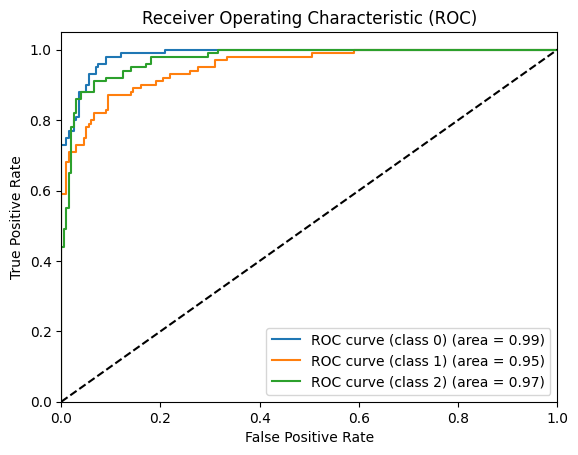

In [49]:
# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

# Calculer les métriques supplémentaires
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'ROC-AUC: {roc_auc:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Tracer la courbe ROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [50]:
# Afficher 5 images aléatoires par classe
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [51]:
classes = train_dataset.classes  # Utilisez les mêmes classes que pour l'entraînement
for cls in classes:
    cls_idx = train_dataset.class_to_idx[cls]
    cls_indices = [i for i, label in enumerate(train_dataset.targets) if label == cls_idx]
    random_indices = np.random.choice(cls_indices, 5, replace=False)
    print(f"Classe: {cls}")
    for idx in random_indices:
        img, _ = train_dataset[idx]
        imshow(img, cls)

Output hidden; open in https://colab.research.google.com to view.